In [28]:
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys 
sys.path.append("..") 
from utils.bms import fit_bms, calc_lme
from utils.viz import viz
viz.get_style()

In [36]:
# summary model fitting information
models = ['MOS', 'FLR']
fit_sub_info = []

for i, m in enumerate(models):
    with open(f'../fits/exp1data/fit_sub_info-{m}-bms.pkl', 'rb')as handle:
        fit_info = pickle.load(handle)
    # get the subject list 
    if i==0: subj_lst = fit_info.keys() 
    # get log post
    log_post = [fit_info[idx]['log_post'] for idx in subj_lst]
    log_like = [fit_info[idx]['log_like'] for idx in subj_lst]
    bic      = [fit_info[idx]['bic'] for idx in subj_lst]
    h        = [fit_info[idx]['H'] for idx in subj_lst]
    n_param  = fit_info[list(subj_lst)[0]]['n_param']
    fit_sub_info.append({
        'log_post': log_post,
        'log_like': log_like, 
        'bic': bic, 
        'n_param': n_param, 
        'H': h
    })

### The log model evidence penalizes the number of parameters more

In [37]:
# lme v.s. bic
lme = np.vstack([calc_lme(fit_info) for fit_info in fit_sub_info]).T
bic = np.vstack([-.5*np.array(fit_info['bic']) for fit_info in fit_sub_info]).T

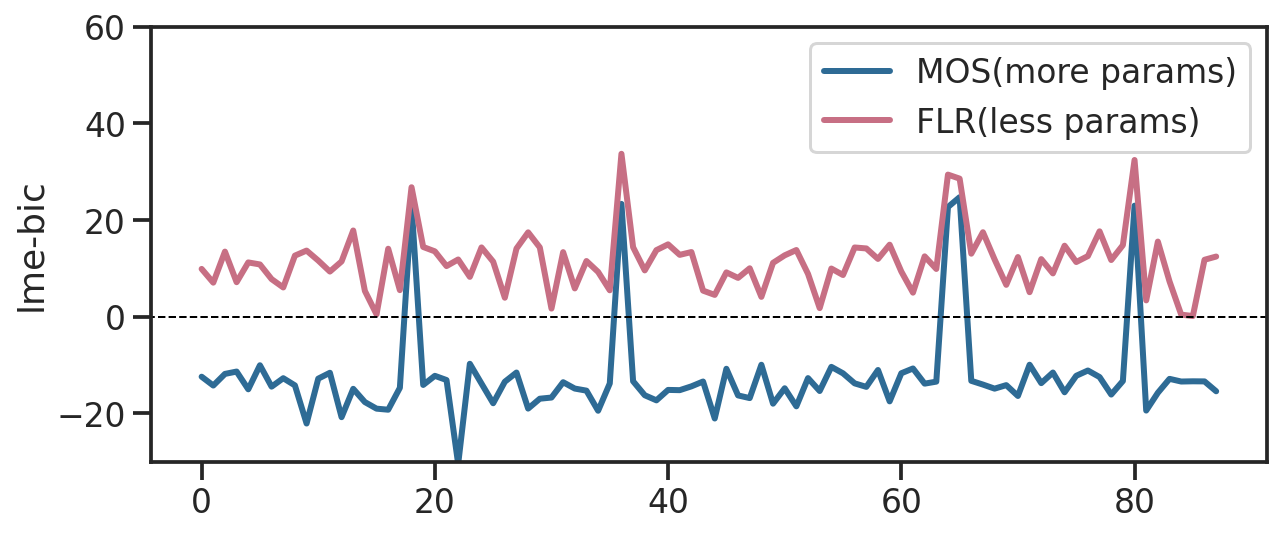

In [38]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.arange(len(lme)), y=lme[:, 0]-bic[:, 0], color=viz.Blue, lw=3)
sns.lineplot(x=np.arange(len(lme)), y=lme[:, 1]-bic[:, 1], color=viz.Red, lw=3)
plt.axhline(y=0, xmin=-5, xmax=90, lw=1, color='k', ls='--')
plt.ylabel('lme-bic')
plt.ylim([-30, 60])
plt.legend(['MOS(more params)', 'FLR(less params)'])


### Is it because the log prior? or the hessian? 

#### Remove the log prior

In [39]:
def calc_lme2(fit_info):
    '''Calculate Log Model Evidence
    Turn a list of fitting results of different
    model into a matirx lme. Ns means number of subjects, 
    Nm is the number of models.
    Args:
        fit_info: [dict,] A dict of model's fitting info
            - log_post: opt parameters
            - log_like: log likelihood
            - param: the optimal parameters
            - n_param: the number of parameters
            - aic
            - bic
            - H: hessian matrix 
    
    Outputs:
        lme: [Ns, Nm] log model evidence 
                
    '''
    lme  = []
    for s in range(len(fit_info['log_post'])):
        # log|-H|
        h = np.log(np.linalg.det(fit_info['H'][s]))
        # log p(D,θ*|m) + .5(log(d) - log|-H|) 
        l = fit_info['log_like'][s] + \
            .5*(fit_info['n_param']*np.log(2*np.pi)-h)
        lme.append(l)
    # use BIC if any Hessians are degenerate 
    ind = np.isnan(lme) | np.isinf(lme)| (np.imag(lme)!=0)
    if any(ind.reshape([-1])): lme = -.5 * np.array(fit_info['bic'])
            
    return np.array(lme)

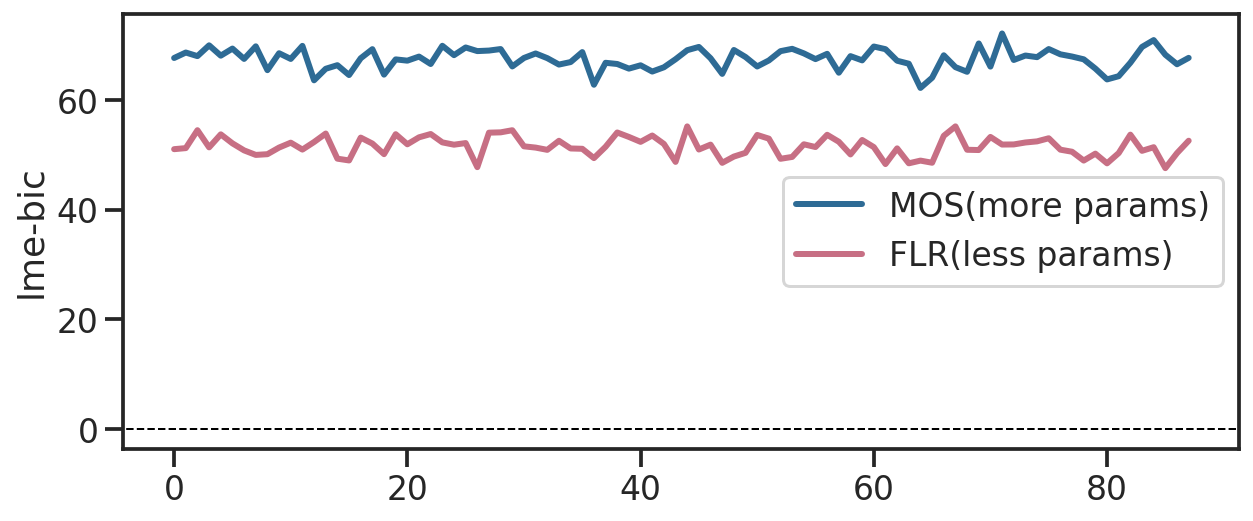

In [41]:
# lme v.s. bic
lme = np.vstack([calc_lme2(fit_info) for fit_info in fit_sub_info]).T
bic = np.vstack([-.5*np.array(fit_info['bic']) for fit_info in fit_sub_info]).T
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.arange(len(lme)), y=lme[:, 0]-bic[:, 0], color=viz.Blue, lw=3)
sns.lineplot(x=np.arange(len(lme)), y=lme[:, 1]-bic[:, 1], color=viz.Red, lw=3)
plt.axhline(y=0, xmin=-5, xmax=90, lw=1, color='k', ls='--')
plt.ylabel('lme-bic')
plt.legend(['MOS(more params)', 'FLR(less params)'])

#### Replace the Hessian

In [44]:
def calc_lme3(fit_info):
    '''Calculate Log Model Evidence
    Turn a list of fitting results of different
    model into a matirx lme. Ns means number of subjects, 
    Nm is the number of models.
    Args:
        fit_info: [dict,] A dict of model's fitting info
            - log_post: opt parameters
            - log_like: log likelihood
            - param: the optimal parameters
            - n_param: the number of parameters
            - aic
            - bic
            - H: hessian matrix 
    
    Outputs:
        lme: [Ns, Nm] log model evidence 
                
    '''
    lme  = []
    for s in range(len(fit_info['log_post'])):
        # log|-H|
        h = np.log(np.linalg.det(fit_info['H'][s]))
        # log p(D,θ*|m) + .5(log(d) - log|-H|) 
        l = fit_info['log_post'][s] - fit_info['n_param']*np.log(180) 
        lme.append(l)
    # use BIC if any Hessians are degenerate 
    ind = np.isnan(lme) | np.isinf(lme)| (np.imag(lme)!=0)
    if any(ind.reshape([-1])): lme = -.5 * np.array(fit_info['bic'])
            
    return np.array(lme)

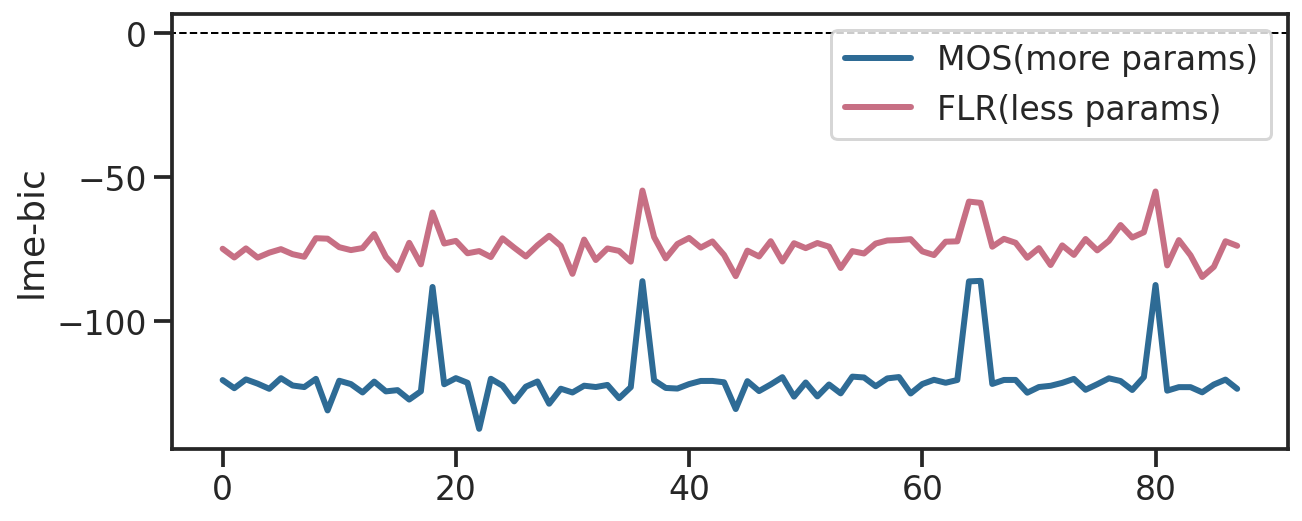

In [45]:
# lme v.s. bic
lme = np.vstack([calc_lme3(fit_info) for fit_info in fit_sub_info]).T
bic = np.vstack([-.5*np.array(fit_info['bic']) for fit_info in fit_sub_info]).T
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.arange(len(lme)), y=lme[:, 0]-bic[:, 0], color=viz.Blue, lw=3)
sns.lineplot(x=np.arange(len(lme)), y=lme[:, 1]-bic[:, 1], color=viz.Red, lw=3)
plt.axhline(y=0, xmin=-5, xmax=90, lw=1, color='k', ls='--')
plt.ylabel('lme-bic')
plt.legend(['MOS(more params)', 'FLR(less params)'])